## SCMcluster using the Leukemia Dataset


Leukemia Dataset Results:

Final Labels:
 [1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1]

Leukemia Dataset Evaluation Metrics:
Adjusted Rand Index (ARI): 0.1858690905037049
Normalized Mutual Info (NMI): 0.13938683316819436
Adjusted Mutual Info (AMI): 0.13006702163838693
Fowlkes-Mallows Index (FMI): 0.610298275056738
Purity Score: 0.7222222222222222


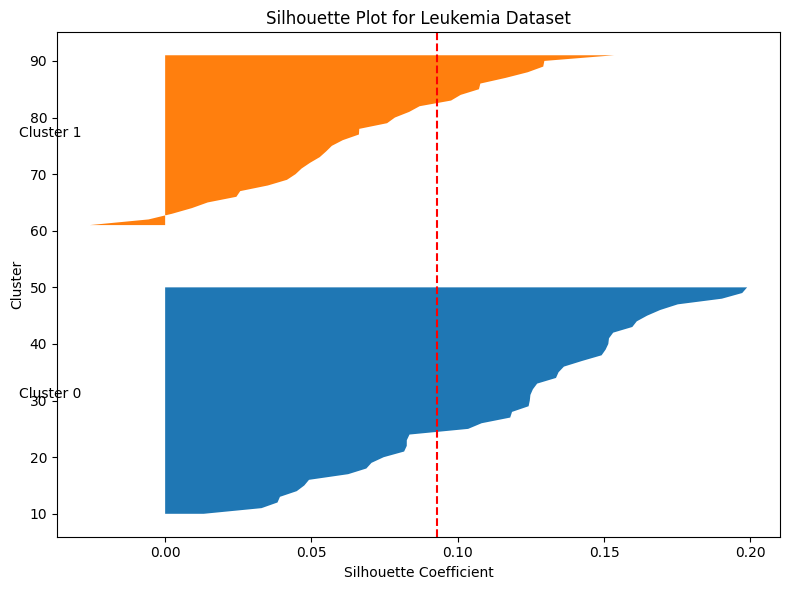

c:\Users\Himanshu Gaur\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


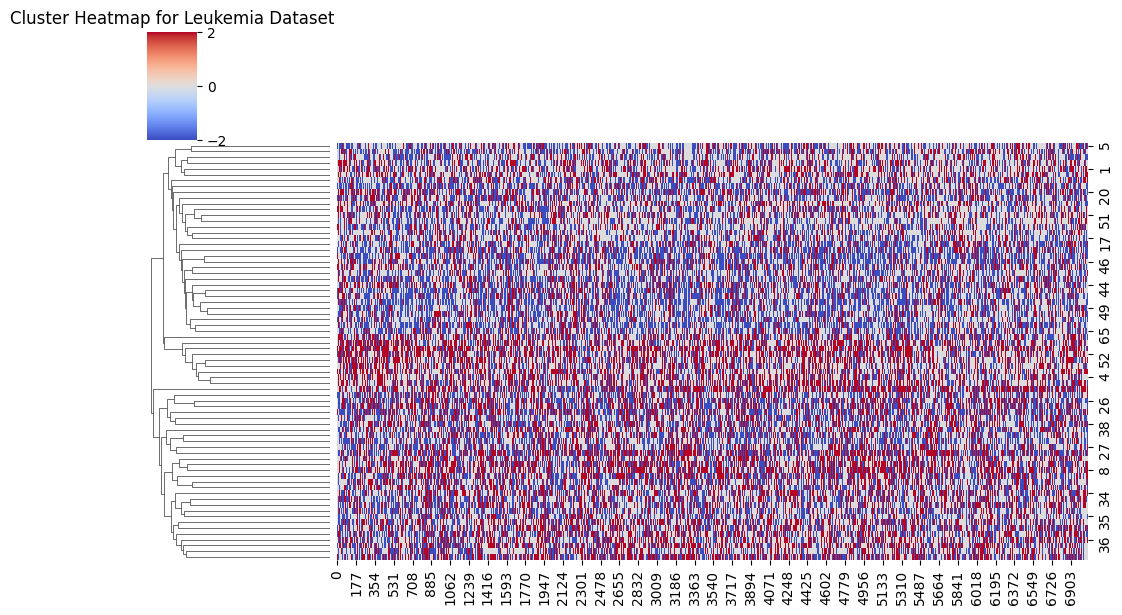

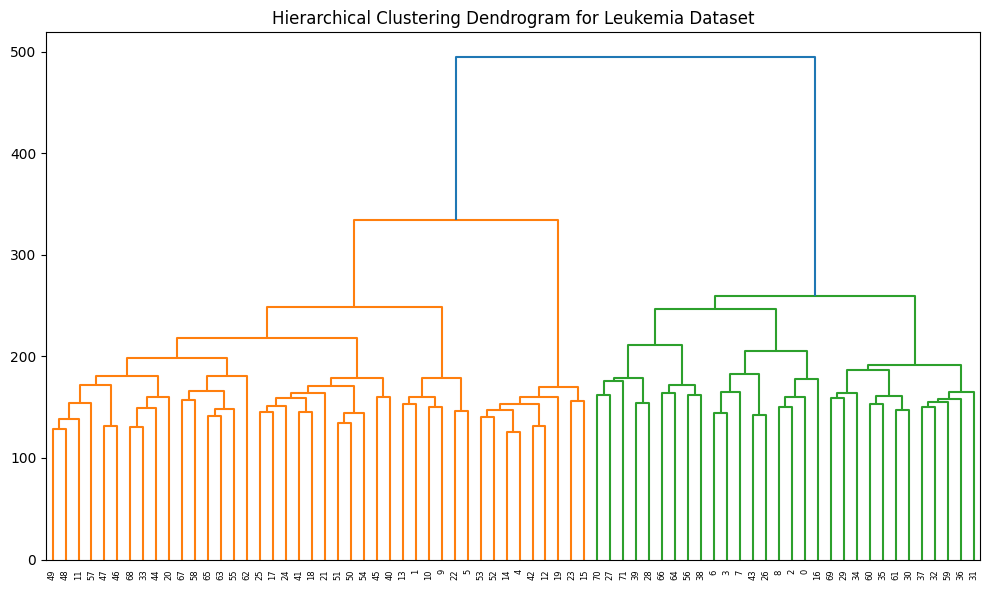

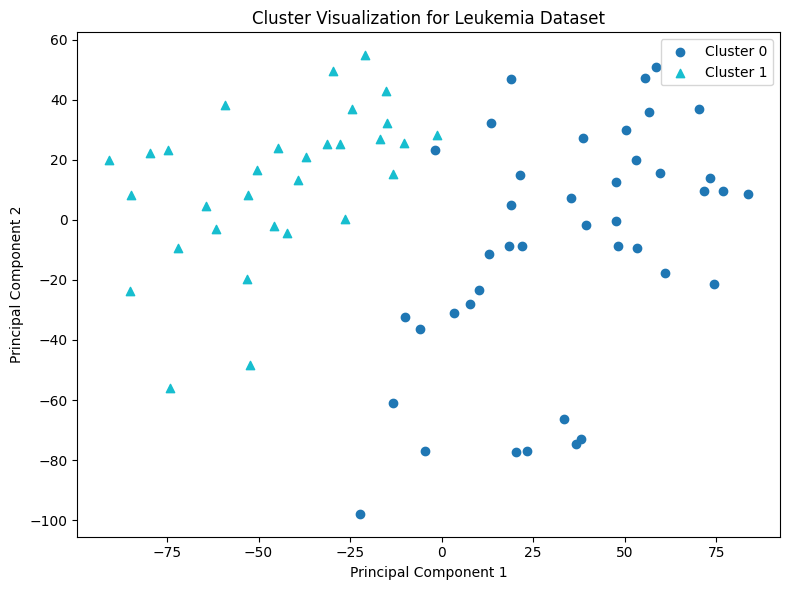


GLIOMA Dataset Results:

Final Labels for GLIOMA Dataset:
 [2 0 2 0 0 2 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 3 2 1 2 2 2 3 2 2 2 2 2 2 1 1 1
 1 3 1 2 1 1 2 3 3 3 3 2 1]

New Dataset Evaluation Metrics:
Adjusted Rand Index (ARI): 0.2755114392930638
Normalized Mutual Info (NMI): 0.4484824847015607
Adjusted Mutual Info (AMI): 0.40162348652438606
Fowlkes-Mallows Index (FMI): 0.46422592173940197
Purity Score: 0.62


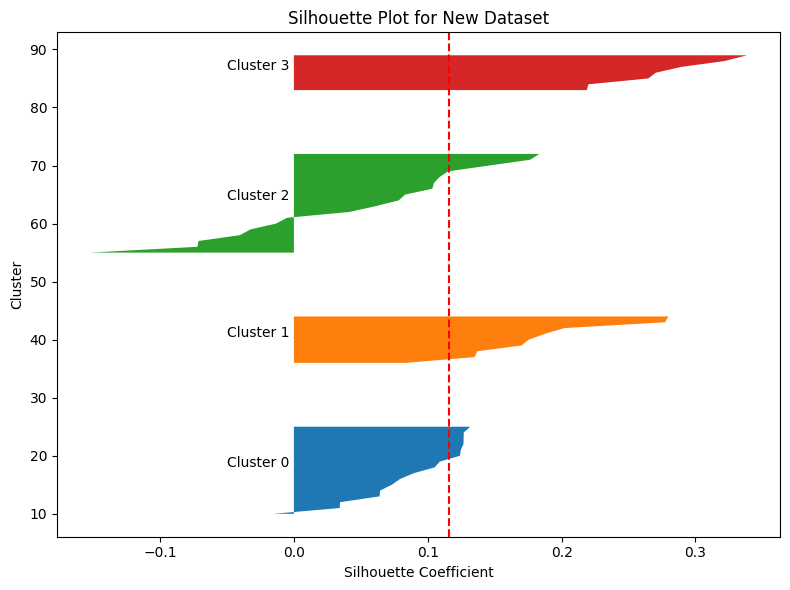

c:\Users\Himanshu Gaur\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


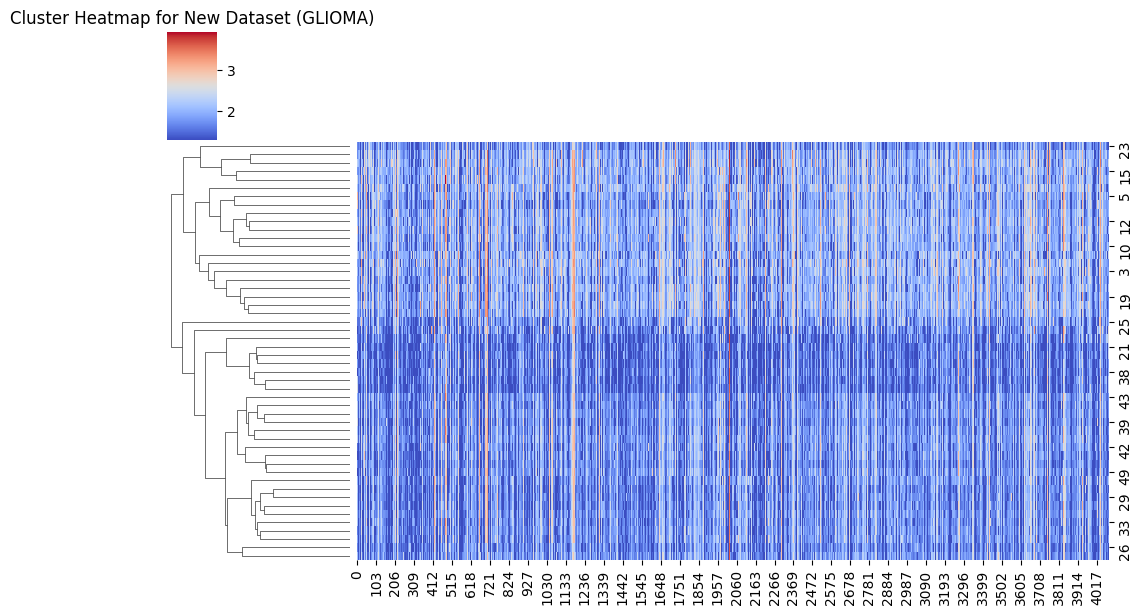

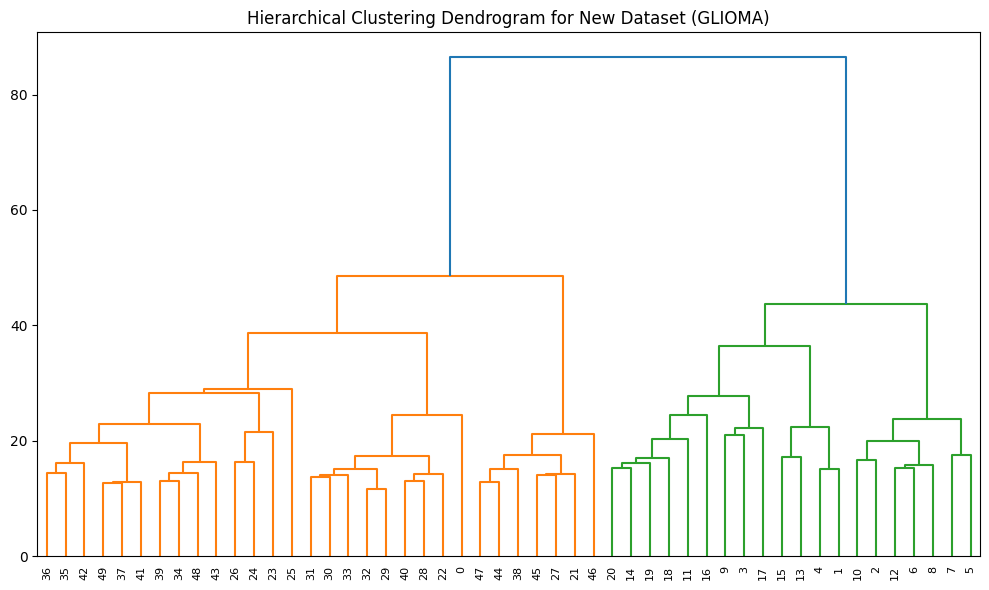

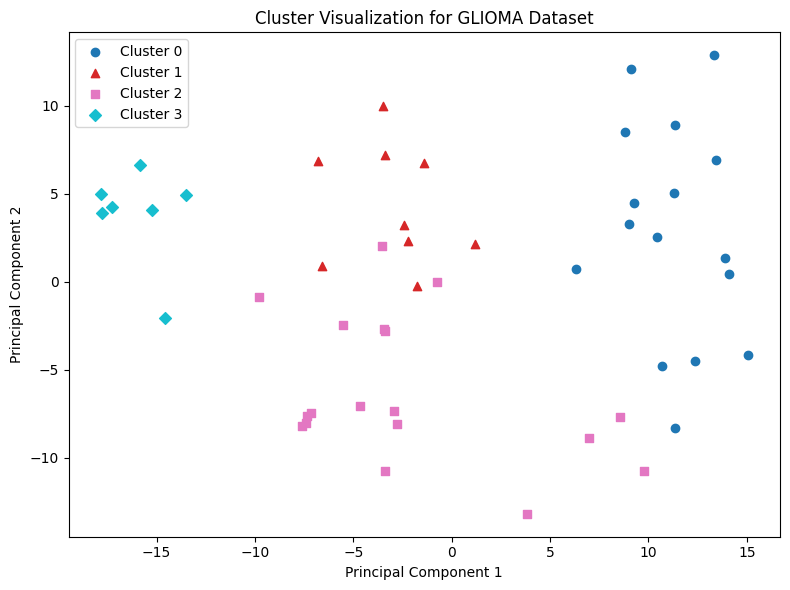


New Dataset Supervised Validation:
Cross-Validation Accuracy Scores: [0.7 0.6 0.8 0.9 0.9]
Mean Accuracy: 0.7799999999999999
Standard Deviation: 0.11661903789690603
Best Accuracy: 0.9


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import os

# ===============================================================
# Load Leukemia Dataset
# ===============================================================
def load_leukemia_local(filepath="leukemia.mat"):  # This is the dataset
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"{filepath} not found.")
    # Load the .mat file
    mat = scipy.io.loadmat(filepath)
    X = mat['X']
    # Extract labels 'Y' if they exist
    y = mat['Y'].flatten() if 'Y' in mat else None
    # Transpose the data if there are more features than samples
    if X.shape[0] > X.shape[1]:
        X = X.T
    return X, y

# ===============================================================
# Load the new dataset (add your new dataset path here)
# ===============================================================
def load_new_dataset(filepath="GLIOMA.mat"):  # This is the new dataset
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"{filepath} not found.")
    # Load the .mat file
    mat = scipy.io.loadmat(filepath)
    X = mat['X']
    # Extract labels 'Y' if they exist
    y = mat['Y'].flatten() if 'Y' in mat else None
    # Transpose the data if there are more features than samples
    if X.shape[0] > X.shape[1]:
        X = X.T
    return X, y

# ===============================================================
# Apply Variance Threshold
# ===============================================================
def apply_variance_threshold(X, threshold=0.03):
    # Remove features with low variance
    return VarianceThreshold(threshold).fit_transform(X)

# ===============================================================
# Custom SNN Clustering
# ===============================================================
def snn_clustering(distance_matrix, k=10, sim_threshold=0.4):
    n = distance_matrix.shape[0]
    # Find k nearest neighbors for each sample
    neighbors = np.argsort(distance_matrix, axis=1)[:, 1:k+1]
    snn_similarity = np.zeros((n, n))
    # Calculate the shared neighbors similarity
    for i in range(n):
        for j in range(i+1, n):
            shared = len(set(neighbors[i]).intersection(neighbors[j]))
            snn_similarity[i, j] = snn_similarity[j, i] = shared / k
    labels = [-1] * n
    cluster_id = 0
    # Assign clusters based on shared neighbors
    for i in range(n):
        if labels[i] == -1:
            labels[i] = cluster_id
            for j in range(n):
                if snn_similarity[i, j] >= sim_threshold and labels[j] == -1:
                    labels[j] = cluster_id
            cluster_id += 1
    return labels

# ===============================================================
# Custom KMeans 
# ===============================================================
def custom_kmeans(X, n_clusters=3, max_iters=100):
    np.random.seed(42)
    # Randomly select initial centroids
    centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
    for _ in range(max_iters):
        # Calculate distances from each point to centroids
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        # Update centroids based on the mean of assigned points
        new_centroids = np.array([X[labels == i].mean(axis=0) if len(X[labels == i]) > 0 else centroids[i] for i in range(n_clusters)])
        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return labels

# ===============================================================
# Build Co-association Matrix
# ===============================================================
def build_coassociation_matrix(X, distance_matrix, n_clusters):
    n = X.shape[0]
    methods = [
        lambda: snn_clustering(distance_matrix, k=10, sim_threshold=0.4),
        lambda: custom_kmeans(X, n_clusters=n_clusters)
    ]
    co_matrix = np.zeros((n, n))
    # Combine clustering results from multiple methods
    for model in methods:
        labels = model()
        matrix = np.equal.outer(labels, labels).astype(int)
        co_matrix += matrix / len(methods)
    return co_matrix

# ===============================================================
# Spectral Clustering from Co-association Matrix (SCM)
# ===============================================================
def scm_clustering(co_matrix, n_clusters=3):
    # Compute the Laplacian matrix
    D = np.diag(co_matrix.sum(axis=1))
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
    L = np.identity(co_matrix.shape[0]) - D_inv_sqrt @ co_matrix @ D_inv_sqrt
    eigvals, eigvecs = np.linalg.eigh(L)
    X_reduced = eigvecs[:, :n_clusters]
    return custom_kmeans(X_reduced, n_clusters=n_clusters)

# ===============================================================
# PCA (Principal Component Analysis)
# ===============================================================
def custom_pca(X, num_components=2):
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    # Compute covariance matrix and eigen decomposition
    cov = np.cov(X_centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    top_components = eigvecs[:, np.argsort(eigvals)[::-1][:num_components]]
    return np.dot(X_centered, top_components)

# ===============================================================
# Cluster Visualization with Different Colors and Legend Shapes
# ===============================================================
def visualize_clusters(X, labels, title="Cluster Visualization"):
    reduced = custom_pca(X, num_components=2)
    plt.figure(figsize=(8, 6))

    # Set colors for each cluster and assign different markers
    unique_labels = np.unique(labels)
    markers = ['o', '^', 's', 'D']  # Circle, Triangle, Square, Diamond
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    for i, label in enumerate(unique_labels):
        cluster_data = reduced[labels == label]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], color=colors[i], marker=markers[i], label=f'Cluster {label}')

    # Customize legend and plot
    plt.legend()
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.tight_layout()
    plt.show()

# ===============================================================
# Main
# ===============================================================
# Load and preprocess the Leukemia dataset
X, y = load_leukemia_local("leukemia.mat") # This is the dataset
X_filtered = apply_variance_threshold(X, threshold=0.03)
distance_matrix = pairwise_distances(X_filtered)
n_clusters = 2  # for the leukemia dataset
co_matrix = build_coassociation_matrix(X_filtered, distance_matrix, n_clusters=n_clusters)
final_labels = scm_clustering(co_matrix, n_clusters=n_clusters)

# Visualize Leukemia Dataset Results
print("\nLeukemia Dataset Results:")
print("\nFinal Labels:\n", final_labels)
if y is not None and len(y) == len(final_labels):
    print("\nLeukemia Dataset Evaluation Metrics:")
    print("Adjusted Rand Index (ARI):", metrics.adjusted_rand_score(y, final_labels))
    print("Normalized Mutual Info (NMI):", metrics.normalized_mutual_info_score(y, final_labels))
    print("Adjusted Mutual Info (AMI):", metrics.adjusted_mutual_info_score(y, final_labels))
    print("Fowlkes-Mallows Index (FMI):", metrics.fowlkes_mallows_score(y, final_labels))
    print("Purity Score:", purity_score(y, final_labels))

# Silhouette Plot for Leukemia
silhouette_vals = silhouette_samples(X_filtered, final_labels)
y_lower = 10
plt.figure(figsize=(8, 6))
for i in np.unique(final_labels):
    ith_cluster_silhouette_vals = silhouette_vals[final_labels == i]
    ith_cluster_silhouette_vals.sort()
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.tab10(i % 10)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, facecolor=color)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10
plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
plt.title("Silhouette Plot for Leukemia Dataset")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

# Create Clustermap for Leukemia Dataset
df = pd.DataFrame(X_filtered)
df["cluster"] = final_labels
df_sorted = df.sort_values("cluster").drop("cluster", axis=1)
sns.clustermap(df_sorted, cmap="coolwarm", figsize=(10, 6), col_cluster=False)
plt.title("Cluster Heatmap for Leukemia Dataset")
plt.show()

# Create Dendrogram for Leukemia Dataset
linked = linkage(X_filtered, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("Hierarchical Clustering Dendrogram for Leukemia Dataset")
plt.tight_layout()
plt.show()

# Visualize Clusters for Leukemia Dataset with different colors and markers
visualize_clusters(X_filtered, final_labels, title="Cluster Visualization for Leukemia Dataset")

# Load and preprocess the new dataset (number of clusters = 4)
X_new, y_new = load_new_dataset("GLIOMA.mat") # This is the new dataset
X_new_filtered = apply_variance_threshold(X_new, threshold=0.03)
distance_matrix_new = pairwise_distances(X_new_filtered)
n_clusters_new = 4  # for the new dataset
co_matrix_new = build_coassociation_matrix(X_new_filtered, distance_matrix_new, n_clusters=n_clusters_new)
final_labels_new = scm_clustering(co_matrix_new, n_clusters=n_clusters_new)

# Visualize New Dataset Results (GLIOMA)
print("\nGLIOMA Dataset Results:")
print("\nFinal Labels for GLIOMA Dataset:\n", final_labels_new)
if y_new is not None and len(y_new) == len(final_labels_new):
    print("\nNew Dataset Evaluation Metrics:")
    print("Adjusted Rand Index (ARI):", metrics.adjusted_rand_score(y_new, final_labels_new))
    print("Normalized Mutual Info (NMI):", metrics.normalized_mutual_info_score(y_new, final_labels_new))
    print("Adjusted Mutual Info (AMI):", metrics.adjusted_mutual_info_score(y_new, final_labels_new))
    print("Fowlkes-Mallows Index (FMI):", metrics.fowlkes_mallows_score(y_new, final_labels_new))
    print("Purity Score:", purity_score(y_new, final_labels_new))

    # Silhouette Plot for New Dataset
    silhouette_vals_new = silhouette_samples(X_new_filtered, final_labels_new)
    y_lower = 10
    plt.figure(figsize=(8, 6))
    for i in np.unique(final_labels_new):
        ith_cluster_silhouette_vals = silhouette_vals_new[final_labels_new == i]
        ith_cluster_silhouette_vals.sort()
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.tab10(i % 10)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, facecolor=color)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
        y_lower = y_upper + 10
    plt.axvline(x=np.mean(silhouette_vals_new), color="red", linestyle="--")
    plt.title("Silhouette Plot for New Dataset")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.show()

# Create Clustermap for the new dataset (GLIOMA)
df_new = pd.DataFrame(X_new_filtered)
df_new["cluster"] = final_labels_new
df_new_sorted = df_new.sort_values("cluster").drop("cluster", axis=1)
sns.clustermap(df_new_sorted, cmap="coolwarm", figsize=(10, 6), col_cluster=False)
plt.title("Cluster Heatmap for New Dataset (GLIOMA)")
plt.show()

# Create Dendrogram for the new dataset (GLIOMA)
linked_new = linkage(X_new_filtered, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked_new, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("Hierarchical Clustering Dendrogram for New Dataset (GLIOMA)")
plt.tight_layout()
plt.show()

# Visualize Clusters for New Dataset (GLIOMA)
visualize_clusters(X_new_filtered, final_labels_new, title="Cluster Visualization for GLIOMA Dataset")

# Perform k-NN classification for the new dataset (cross-validation)
if y_new is not None:
    knn_new = KNeighborsClassifier(n_neighbors=3)
    scores_new = cross_val_score(knn_new, X_new_filtered, y_new, cv=5)
    print("\nNew Dataset Supervised Validation:")
    print("Cross-Validation Accuracy Scores:", scores_new)
    print("Mean Accuracy:", np.mean(scores_new))
    print("Standard Deviation:", np.std(scores_new))
    print("Best Accuracy:", np.max(scores_new))
